# Regressione polinomiale su un dataset sintetico univariato

## Generazione del dataset sintetico

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Imposta alcuni parametri per la visualizzazione degli array.
np.set_printoptions(threshold=55, edgeitems=10, suppress=True)

# Abilita la visualizzazione dei grafici all'interno del notebook.
%matplotlib inline

# Specifica il numero di righe del dataset sintetico da generare.
DATASET_SIZE = 100

# Genera un dataset sintetico con due colonne [x y] dove:
# x è campionata da una distribuzione uniforme.
# y è una funzione quadratica di x con del rumore aggiunto.
x = 10 * np.random.rand(DATASET_SIZE)
y = x ** 2 + 5 * np.random.randn(DATASET_SIZE)
space = np.arange(-2, 12, 0.01)
dataset = np.hstack([x.reshape(DATASET_SIZE, 1), y.reshape(DATASET_SIZE, 1)])

## Raccolta di informazioni sul dataset generato

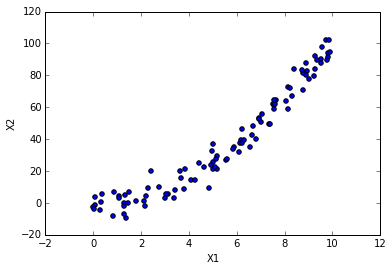

In [3]:
# Disegna il grafico di dispersione del dataset.
plt.figure()
plt.scatter(x, y)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Regressione polinomiale univariata

Si definisce, innanzi tutto, il grado del polinomio di migliore approssimazione di esempio da costruire.

In [4]:
# Specifica il grado per la costruzione del polinomio di esempio.
degree = 2

### Metodo 1: regressione polinomiale mediante Scikit-learn

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


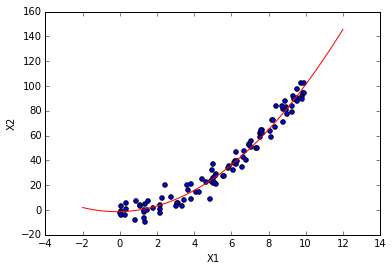

In [5]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression

class PolynomialRegression(BaseEstimator):
    """Classe per la regressione polinomiale mediante Scikit-learn.

    La presente classe è costruita a partire dalla classe BaseEstimator di Scikit-learn.

    Args:
        deg: grado desiderato per il polinomio, o None se non specificato.

    """
    def __init__(self, deg=None):
        self.deg = deg

    def fit(self, X, y, deg=None):
        """Effettua l'apprendimento del modello di regressione polinomiale.

        Args:
            x: vettore delle ascisse di un training set univariato.
            y: vettore degli elementi dipendenti di un training set univariato.

        """
        # Utilizza un modello di regressione lineare per l'apprendimento del polinomio
        # effettuando l'apprendimento di tale modello mediante la matrice di Vandermonde costruita.
        # Si specifica il parametro fit_intercept=False perché l'apprendimento del coefficiente riguardante
        # l'intercetta è comunque effettuato data la costruzione esplicita della matrice di Vandermonde.
        self.model = LinearRegression(fit_intercept=False)
        self.model.fit(np.vander(X, N=self.deg + 1), y)

    def predict(self, x):
        """Effettua le predizioni del modello di regressione polinomiale.

        Args:
            x: vettore delle ascisse sulle quali valutare il polinomio di migliore approssimazione.

        Returns:
            predictions: vettore delle valutazioni effettuate dal polinomio di migliore approssimazione.

        """
        predictions = self.model.predict(np.vander(x, N=self.deg + 1))
        return predictions

best_estimator = PolynomialRegression(deg=2)
best_estimator.fit(x, y)
print("Coefficienti determinati:\n{0}".format(best_estimator.model.coef_))

predictions = best_estimator.predict(space)
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Un'altra possibilità per effettuare regressione polinomiale è l'utilizzo della classe PolynomialFeatures per la costruzione di un dataset costituito da feature polinomiali in combinazione con la classe LinearRegression per la regressione lineare su tale dataset. Il risultato di tale composizione è la regressione polinomiale desiderata. La composizione di più operazioni per costruire un modello complesso può essere automatizzata mediante make_pipeline, che costruisce un'istanza della classe Pipeline per l'esecuzione delle operazioni sul dataset nell'ordine indicato.

N.B.: si consideri che la classe PolynomialFeatures costruisce anche le feature dell'interazione tra le variabili, ovvero feature del tipo $x_i * x_j$. Tali feature sono assenti nel caso precedente, sebbene si possa eventualmente costruire una matrice di Vandermonde che presenti anche le interazioni descritte.

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


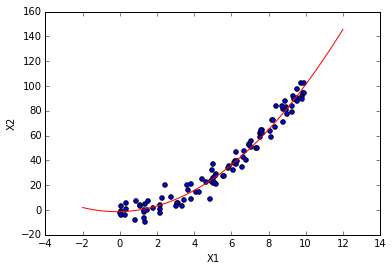

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

xs = x[:, np.newaxis]
ys = y[:, np.newaxis]
spaces = space[:, np.newaxis]

polynomial_model = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=False))
polynomial_model.fit(xs, ys)
print("Coefficienti determinati:\n{0}".format(polynomial_model.steps[-1][1].coef_[0, ::-1]))

predictions = polynomial_model.predict(spaces)
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Si effettua, di seguito, la regressione polinomiale in modo analogo al precedente, ma senza creare un oggetto di tipo Pipeline.

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


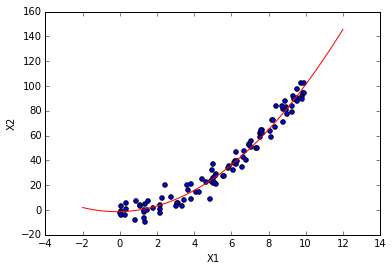

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

polynomial_features = PolynomialFeatures(2)
polynomial_xs = polynomial_features.fit_transform(xs)

linear_regression = LinearRegression(fit_intercept=False)
linear_regression.fit(polynomial_xs, ys)

print("Coefficienti determinati:\n{0}".format(linear_regression.coef_[0, ::-1]))

polynomial_spaces = polynomial_features.fit_transform(spaces)
predictions = linear_regression.predict(polynomial_spaces)
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Metodo 2: implementazione ed esecuzione mediante NumPy

Si definiscono, di seguito, alcune costanti e funzioni che verranno utilizzate per la costruzione del polinomio di migliore approssimazione.

In [8]:
# Costruisce un polinomio ad una variabile con i coefficienti dati.
def polynomial(coefficients):
   def function(x):
      result = 0
      for c in coefficients:
         result = result * x + c
      return result
   return function

# Costruisce una matrice di Vandermonde del grado specificato.
A = np.vander(x, degree + 1)

#### Regressione polinomiale mediante l'utilizzo della funzione polyfit

Si implementa, di seguito, la regressione polinomiale mediante l'utilizzo della funzione polyfit, la quale è utilizzabile solo nel caso in cui si debba costruire un polinomio univariato, come avviene in questo caso, dato che si ha un dataset con una sola feature.

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


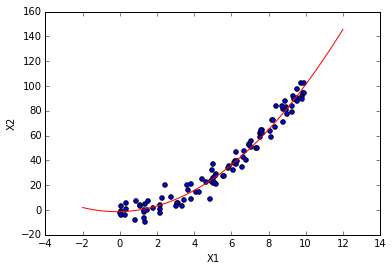

In [9]:
np_coefficients = np.polynomial.polynomial.polyfit(x, y, degree)
np_coefficients = np_coefficients[::-1]
print("Coefficienti determinati:\n{0}".format(np_coefficients))

np_best_estimator = polynomial(np_coefficients)
predictions = list(map(np_best_estimator, space))
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#### Regressione polinomiale mediante la risoluzione del sistema delle equazioni normali

Si implementa, di seguito, la regressione polinomiale mediante la risoluzione del sistema delle equazioni normali.

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


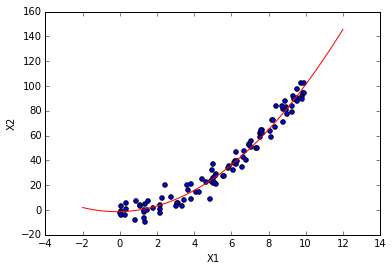

In [10]:
np_coefficients = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, y))
print("Coefficienti determinati:\n{0}".format(np_coefficients))
np_best_estimator = polynomial(np_coefficients)

predictions = list(map(np_best_estimator, space))
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#### Regressione polinomiale mediante la risoluzione del problema dei minimi quadrati

Si implementa, di seguito, la regressione polinomiale mediante la risoluzione del problema dei minimi quadrati.

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


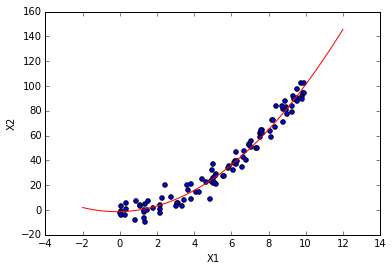

In [11]:
np_coefficients = np.linalg.lstsq(A, y)[0]
print("Coefficienti determinati:\n{0}".format(np_coefficients))
np_best_estimator = polynomial(np_coefficients)

predictions = list(map(np_best_estimator, space))
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#### Regressione polinomiale mediante la decomposizione QR

Si implementa, di seguito, la regressione polinomiale mediante la decomposizione QR.

Tale metodo di risoluzione è solitamente preferito rispetto alla risoluzione del sistema delle equazioni normali perché esso permette di ottenere una migliore stabilità numerica al crescere della dimensione del problema mantenendo un costo accettabile in termini di prestazioni.

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


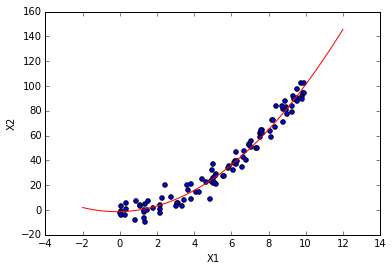

In [12]:
# Effettua la fattorizzazione QR della matrice di Vandermonde.
Q, R = np.linalg.qr(A)

# Effettua il prodotto tra Q.T e y.
Qb = np.dot(Q.T, y)

# Risolve il sistema Rx = Qb.
np_coefficients = np.linalg.solve(R, Qb)
print("Coefficienti determinati:\n{0}".format(np_coefficients))
np_best_estimator = polynomial(np_coefficients)

predictions = list(map(np_best_estimator, space))
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#### Regressione polinomiale mediante la decomposizione ai valori singolari

Si implementa, di seguito, la regressione polinomiale mediante la decomposizione ai valori singolari.

Coefficienti determinati:
[ 0.99539988  0.31987186 -1.34284038]


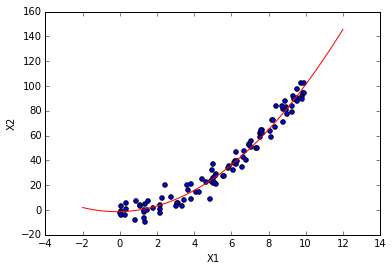

In [13]:
# Effettua la fattorizzazione SVD della matrice di Vandermonde.
U, s, V = np.linalg.svd(A)

np_coefficients = np.zeros(A.shape[1])

for i in range(len(s)):
    np_coefficients += ((U[:, i].T).dot(y) / s[i]) * V.T[:, i]

print("Coefficienti determinati:\n{0}".format(np_coefficients))

np_best_estimator = polynomial(np_coefficients)

predictions = list(map(np_best_estimator, space))
plt.figure()
plt.scatter(x, y)
plt.plot(space, predictions, 'r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Validazione della regressione polinomiale univariata

N.B.: si considera, per la validazione, il modello di regressione polinomiale precedentemente ottenuto con Scikit-learn.

Si mostra, di seguito, una tabella contenente, al variare del grado adottato per il polinomio di migliore approssimazione, i valori dell'errore, misurato mediante RMSE, e della media e della deviazione standard dell'errore su ciascuno dei fold della K-Fold Cross Validation.

In [14]:
from sklearn import cross_validation

def rms_error(model, x, y):
    y_pred = model.predict(x)
    return np.sqrt(np.mean((y - y_pred) ** 2))

test_results = []

degrees = range(1, 6)

for degree in degrees:
    degree_results = []
    estimator = PolynomialRegression(deg=degree)
    scores = cross_validation.cross_val_score(estimator, x, y, cv=10, scoring=rms_error)
    degree_results = (list(scores))
    degree_results.append(np.mean(scores))
    degree_results.append(np.std(scores))
    test_results.append(degree_results)

# Per ogni grado, dalla prima alla decima riga si mostra il root mean square error (RMSE)
# del polinomio di migliore approssimazione di tale grado. Gli ultimi due valori
# di ciascuna riga rappresentano errore medio e deviazione standard dell'errore.
test_errors_dataframe = pd.DataFrame(np.array(test_results).T, columns=[1, 2, 3, 4, 5])
print(test_errors_dataframe)

            1         2         3         4         5
0   10.066873  7.600489  7.786981  7.656424  7.603983
1   10.030430  5.466002  5.729826  6.140971  6.090973
2    7.978495  5.761330  5.608563  5.524177  5.448458
3    9.844959  5.246590  5.464836  5.626348  5.696151
4   12.652248  6.275273  6.100972  6.006458  6.136981
5   10.243383  6.064850  5.957635  5.811264  5.749837
6    8.142013  4.135013  3.944750  3.854622  3.968239
7    9.332882  3.921876  4.056677  4.159292  4.105768
8    9.603900  5.202348  5.187438  5.432687  5.716178
9   10.034363  3.917061  3.673926  3.534707  3.650292
10   9.792955  5.359083  5.351160  5.374695  5.416686
11   1.218037  1.105224  1.165307  1.168144  1.139044


Si mostra, di seguito, una curva di validazione costituita da una rappresentazione dell'errore, misurato mediante RMSE, del modello al variare del grado del polinomio di migliore approssimazione. L'errore è stato misurato sia sul training set sia sul test set in modo da studiare bias e varianza del modello.

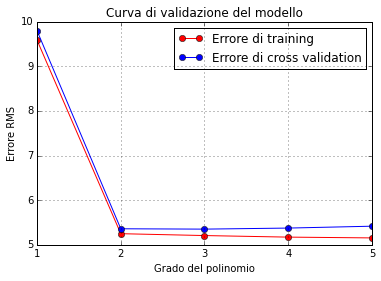

In [80]:
from sklearn.learning_curve import validation_curve

val_train, val_test = validation_curve(PolynomialRegression(), x, y,
                                       'deg', degrees, cv=10,
                                       scoring=rms_error)

train_scores_mean = np.mean(val_train, axis=1)
test_scores_mean = np.mean(val_test, axis=1)

plt.figure()
plt.grid()
plt.title("Curva di validazione del modello")
plt.plot(degrees, train_scores_mean, "o-", color="r", label="Errore di training")
plt.plot(degrees, test_scores_mean, "o-", color="b", label="Errore di cross validation")
plt.xlabel('Grado del polinomio')
plt.ylabel('Errore RMS')
plt.xticks(list(degrees))
plt.legend()
plt.show()

Si mostra, di seguito, una curva di apprendimento costituita da una rappresentazione dell'errore, misurato mediante RMSE, del modello (con deg=2) al variare della dimensione del dataset. L'errore è stato misurato sia sul training set sia sul test set in modo da studiare bias e varianza del modello.

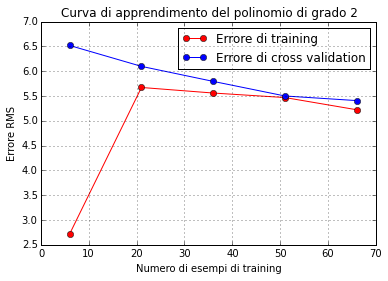

In [78]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores = learning_curve(PolynomialRegression(deg=2), x, y, scoring=rms_error)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.grid()
plt.title("Curva di apprendimento del polinomio di grado 2")
plt.xlabel("Numero di esempi di training")
plt.ylabel("Errore RMS")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Errore di training")
plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Errore di cross validation")
plt.legend()
plt.show()

## Regolarizzazione mediante norma L1 e L2

In caso di overfitting della regressione polinomiale, si può effettuare regolarizzazione con Scikit-learn nelle seguenti modalità:

- Regolarizzazione mediante penalizzazione L1 (Lasso regression)
    - Riferimento:
    http://scikit-learn.org/stable/modules/linear_model.html#lasso
    
- Regolarizzazione mediante penalizzazione L2 (Ridge regression)
    - Riferimento:
    http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression

- Combinazione della regolarizzazione L1 e L2 (Elastic Net)
    - Riferimento:
    http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

Per ulteriori informazioni:
- G. James, D. Witten, T. Hastie, R. Tibshirani - An introduction to Statistical Learning
    - Reperibile all'indirizzo: http://www-bcf.usc.edu/~gareth/ISL/
- T. Hastie, R. Tibshirani, J. Friedman - Elements of Statistical Learning
    - Reperibile all'indirizzo: http://statweb.stanford.edu/~tibs/ElemStatLearn/